In [2]:
from torch import nn
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.categorical import Categorical

In [3]:
import matplotlib.pyplot as plt

In [4]:
c = [MultivariateNormal(torch.tensor([-5.0, 5.0]), torch.eye(2)*0.01**2),
    MultivariateNormal(torch.tensor([5.0, 5.0]), torch.eye(2)*0.01**2),
    MultivariateNormal(torch.tensor([5.0, -5.0]), torch.eye(2)*0.01**2),
    MultivariateNormal(torch.tensor([-5.0, -5.0]), torch.eye(2)*0.01**2)]

pi = torch.tensor([0.25, 0.25, 0.25, 0.25])

def logtarget(x):
    assert x.shape[1] == 2
    logProbaComponent = torch.stack([c[i].log_prob(x) + pi[i].log() for i in range(len(c))])
    return torch.logsumexp(logProbaComponent, 0)

In [30]:
nb_chain = 50
nb_iter = 1000
nb_inner = 5

temperature = torch.linspace(torch.tensor(1.0).log(), torch.tensor(10000000.0).log(), nb_chain).exp()

state = torch.rand((nb_chain,2))*0.00000001
acceptance = torch.zeros(nb_chain)
swapCount = torch.zeros((nb_chain,))
history = torch.zeros((nb_iter, nb_chain, 2))
history[0] = state

In [32]:
for t in range(1, nb_iter):
    perturbation = MultivariateNormal(torch.tensor([0.0, 0.0]), torch.eye(2)*0.001)
    candidate = state + perturbation.sample((nb_chain,))
    logratio = logtarget(candidate)/temperature - logtarget(state)/temperature
    accept = torch.rand((nb_chain,)).log() < logratio
    state[accept,:] = candidate[accept,:]
    history[t] = state
    acceptance += accept*1.0

    # SWAP PHASE
    if t % nb_inner == 0:
        logProba = logtarget(state)
        for j in np.random.permutation(nb_chain-1):
            T_left = temperature[j]
            T_right = temperature[j+1]
            LP_left = logProba[j]
            LP_right = logProba[j+1]

            logA = LP_left/T_right + LP_right/T_left \
                 - LP_left/T_left - LP_right/T_right

            R = torch.exp(logA).cpu()

            if torch.rand(1)[0] < R:
                tmp = state[j,:].detach().clone() 
                state[j,:] = state[j+1,:].detach().clone() 
                state[j+1,:] = tmp

                tmp = logProba[j].detach().clone() 
                logProba[j] = logProba[j+1].detach().clone() 
                logProba[j+1] = tmp

                swapCount[j] += 1

In [33]:
acceptance/nb_iter

tensor([0.3530, 0.3860, 0.3990, 0.4030, 0.4520, 0.4670, 0.4990, 0.5540, 0.5510,
        0.5750, 0.5950, 0.6270, 0.6560, 0.6700, 0.6590, 0.6690, 0.7080, 0.7240,
        0.7110, 0.7560, 0.7910, 0.7960, 0.8180, 0.8380, 0.8370, 0.8780, 0.8960,
        0.9280, 0.9450, 0.9700, 0.9680, 0.9730, 0.9840, 0.9850, 0.9950, 0.9950,
        0.9920, 0.9950, 0.9960, 0.9990, 0.9970, 0.9980, 0.9980, 0.9990, 0.9980,
        0.9980, 0.9990, 0.9990, 0.9990, 0.9990])

<IPython.core.display.Javascript object>


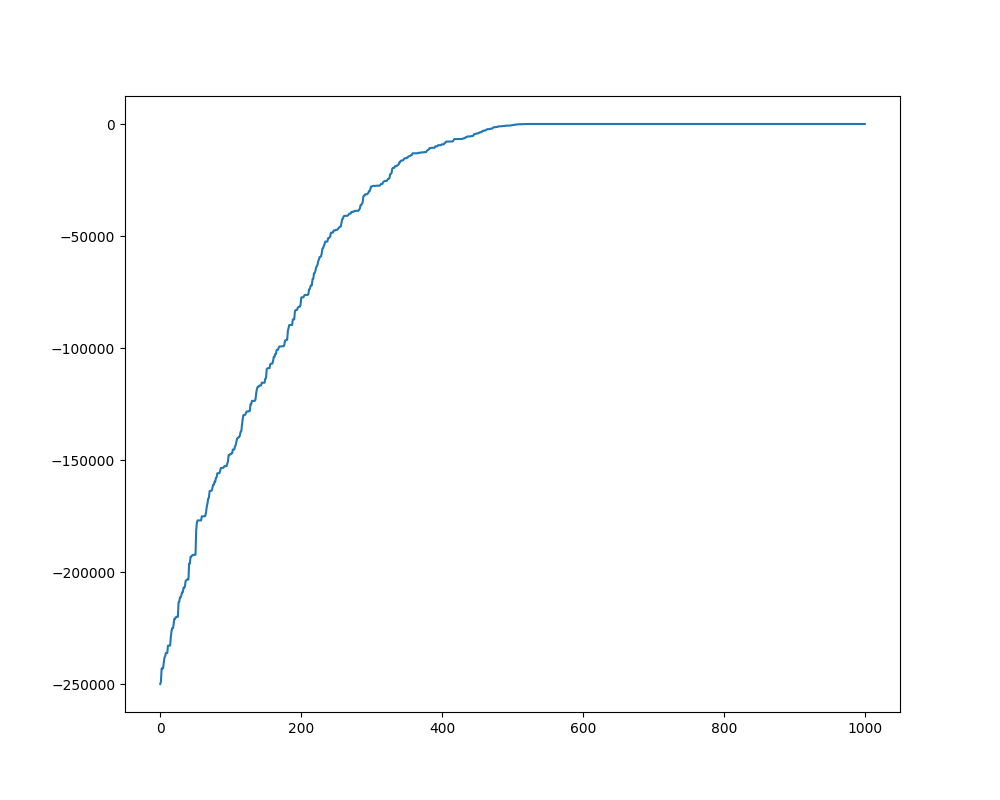

In [34]:
fig = plt.figure(figsize=(10,8))
plt.plot(logtarget(history[:,0,:]))

<IPython.core.display.Javascript object>


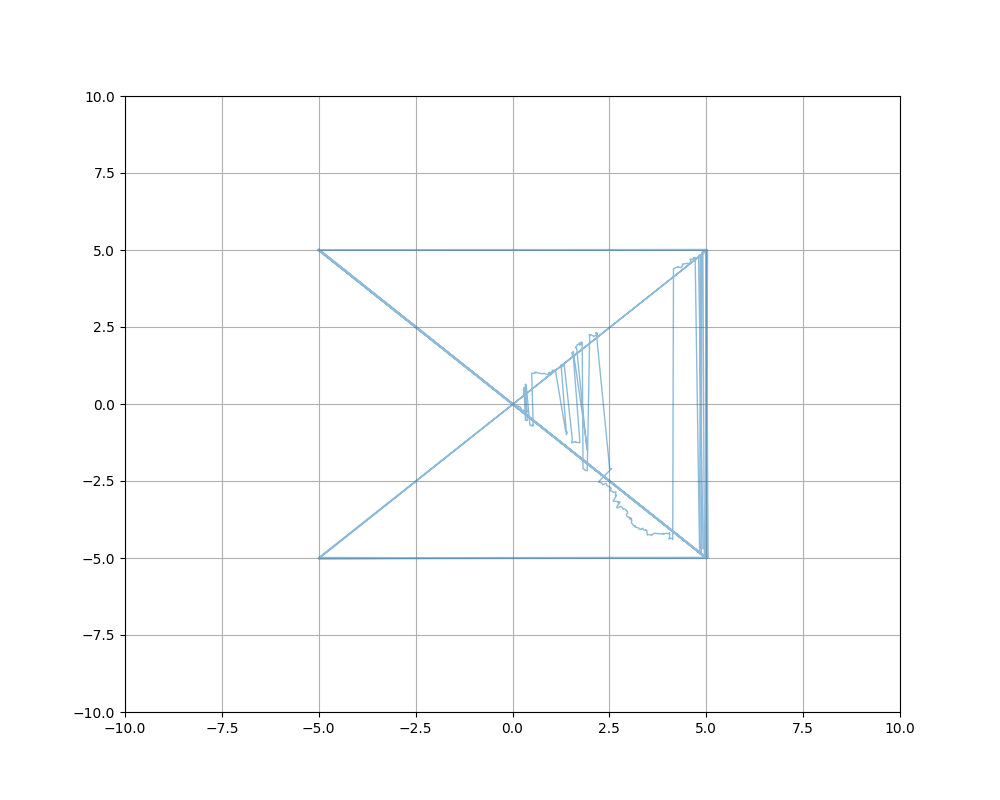

In [42]:
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
chain = 0
plt.plot(history[:,chain,0].detach().clone().cpu().numpy(),
         history[:,chain,1].detach().clone().cpu().numpy(), 
         linewidth=1, 
         alpha=0.5)
plt.axis([-10, 10, -10, 10])
plt.grid()

In [684]:
history[100:].shape

torch.Size([900, 200, 2])

<IPython.core.display.Javascript object>


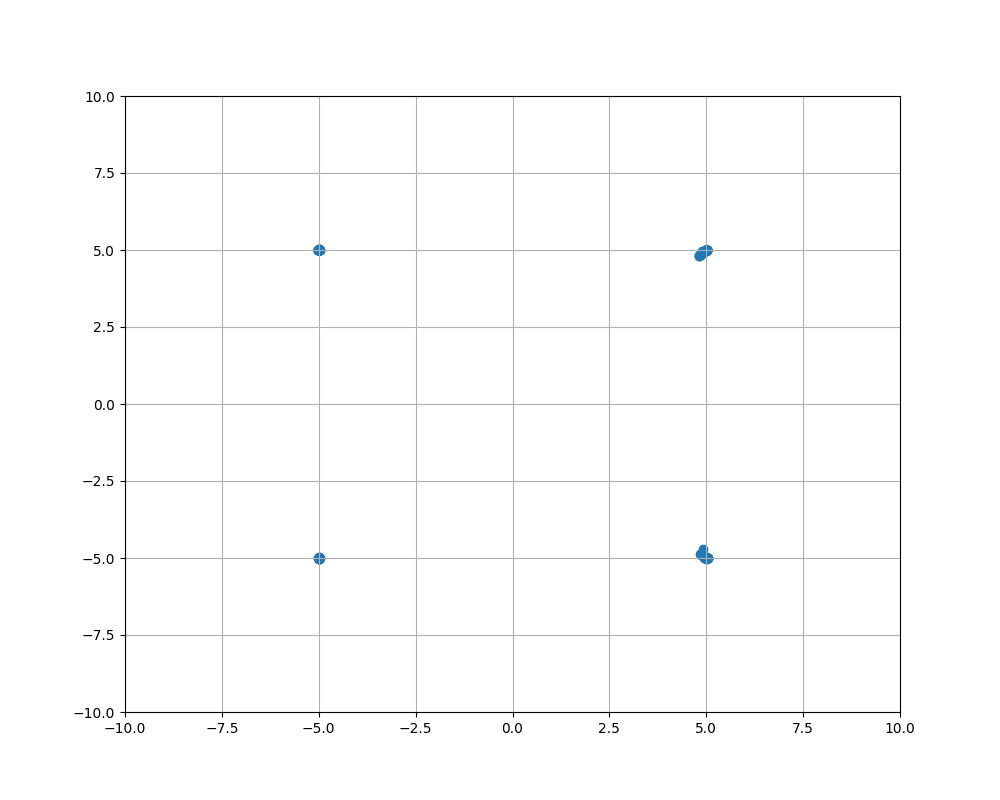

In [40]:
fig = plt.figure(figsize=(10,8))
chain = 0
plt.scatter(history[500:,chain,0].detach().clone().cpu().numpy(),
            history[500:,chain,1].detach().clone().cpu().numpy())
plt.axis([-10, 10, -10, 10])
plt.grid()

<IPython.core.display.Javascript object>


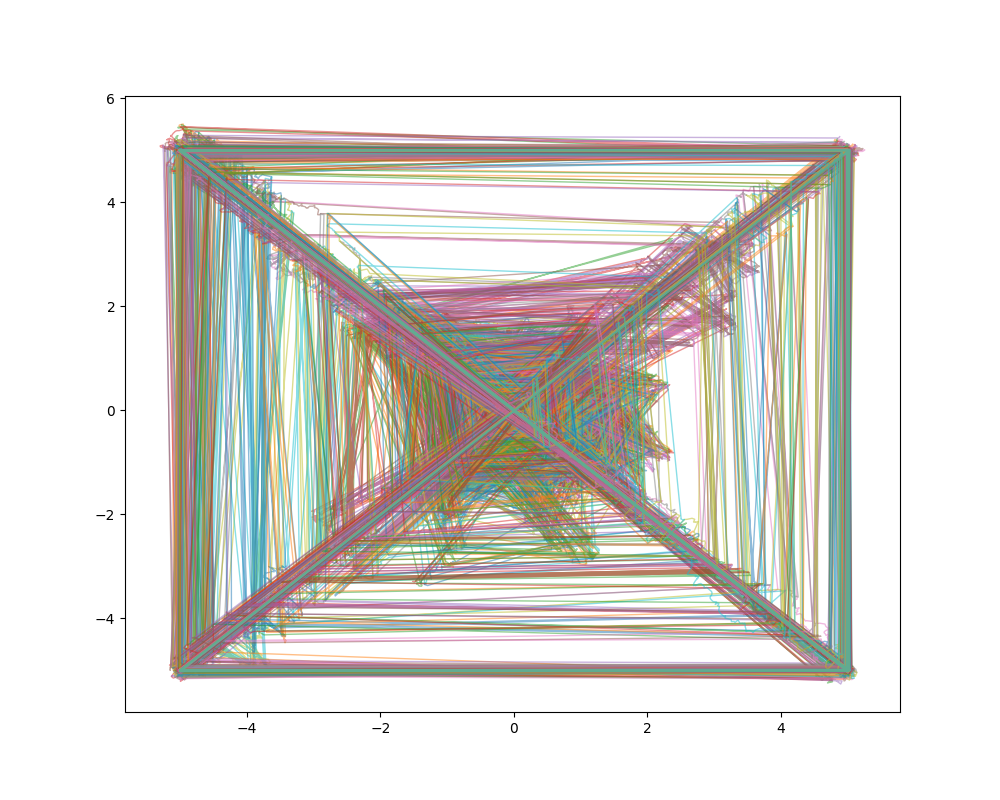

In [41]:
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
for chain in reversed(range(history.shape[1])):
    plt.plot(history[:,chain,0].detach().clone().cpu().numpy(),
             history[:,chain,1].detach().clone().cpu().numpy(), 
             linewidth=1, 
             alpha=0.5)